## 1. Zielsetzung
Dieses Notebook prüft, ob der Zusammenhang zwischen DurchlaufszeitSoll(t) und Termintreue durch das kausale Modell empirisch gestützt werden kann.

## 2. Modellstruktur
Das verwendete Teilmodell basiert auf dem in Kapitel 4.4 entwickelten DAG. Der hier untersuche Graph zeigt alle Knoten, die auf Basis des validierten Datensatzes empirisch zugänglich sind.

## 3. Identifikation
Mittels DoWhy wird überprüft, ob ein identifizierbarer Backdoor-Pfad zwischen Treatment und Outcome vorliegt.

## 4. Schätzung
Die Schätzung erfolgt mithilfe linearer Regression. Der Effektwert wird im Anschluss interpretiert.

## 5. Robustheitsprüfung
Zur Überprüfung der Aussagekraft des geschätzten Effekts werden verschiedene Refuter eingesetzt (Placebo, Random Common Cause, Data Subset).

In [1]:
from dowhy import CausalModel
import pandas as pd
import networkx as nx
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# 1) Daten einlesen
# Datenquelle: konsolidierter Validierungsdatensatz aus Abschnitt 4.5.1
path_validation = r"..\syntheticData\RealDataMerged\mergedManupulated.xlsx"
data_input = pd.read_excel(path_validation)

In [9]:
# 2) CausalModel aufsetzen
G = nx.DiGraph()
edges = [
    ("Rüstzeit", "Rüst- Bearbeitungszeit"),
    ("Bearbeitungszeit", "Rüst- Bearbeitungszeit"),
    ("Rüst- Bearbeitungszeit", "Soll/Ist Durchlaufszeit(t)"),
    ("Soll/Ist Durchlaufszeit(t)", "Abweichung (Tage)"),
    ("DurchlaufszeitSoll(t)", "Abweichung (Tage)"),
    ("Abweichung (Tage)", "Termintreue")
]

G.add_edges_from(edges)

model = CausalModel(
    data=data_input,
    treatment="DurchlaufszeitSoll(t)",
    outcome="Termintreue",
    graph=G
)

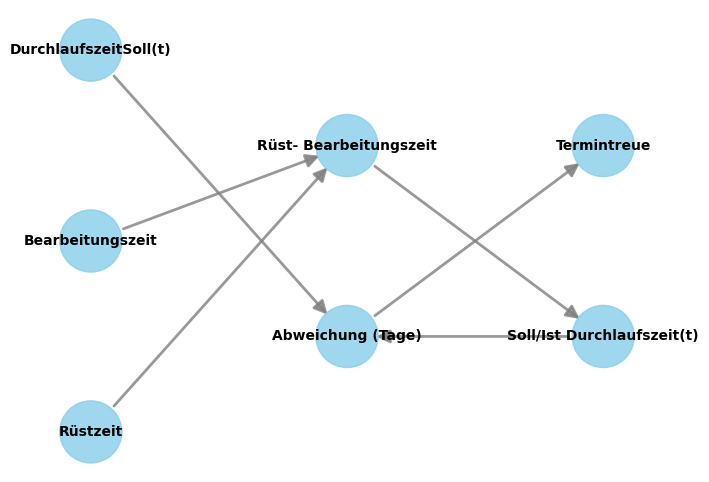

In [ ]:
# 4) kurze Vorschau mit Visueller sicherstellung der Korrekten Implementierung 
model.view_model()

## 3 Identifikation des kausalen Effekts
Im ersten Schritt der Validierung wird geprüft, ob der kausale Effekt der Variable `DurchlaufszeitSoll(t)` auf `Termintreue` im vorgegebenen Modell identifizierbar ist. Dabei generiert DoWhy verschiedene sogenannte *Estimands*, also rechnerisch ausdrückbare Formen kausaler Effekte unter bestimmten Annahmen.

In [ ]:
# 3) Identifizieren
estimand = model.identify_effect()
print(estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
           d                            
────────────────────────(E[Termintreue])
d[DurchlaufszeitSoll(t)]                
Estimand assumption 1, Unconfoundedness: If U→{DurchlaufszeitSoll(t)} and U→Termintreue then P(Termintreue|DurchlaufszeitSoll(t),,U) = P(Termintreue|DurchlaufszeitSoll(t),)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
Estimand expression:
 ⎡         d                                   d                               ↪
E⎢────────────────────(Termintreue)⋅────────────────────────([Abweichung (Tage ↪
 ⎣d[Abweichung (Tage)]              d[DurchlaufszeitSoll(t)]                   ↪

↪    ⎤
↪ )])⎥
↪    ⎦
Estimand assumption 1, Full-mediation: Abweichung (Tage) intercepts (blocks) all directed paths from DurchlaufszeitSoll(t) to T,e,r,m,i,n,t,r,e,u,e.
Estimand assumption 2, First-stage-unconfoundedness: I

Der Output zeigt, dass ein **backdoor-Estimand** erfolgreich identifiziert wurde. Dieser basiert auf der Annahme der *Unconfoundedness*, also dass alle relevanten Störvariablen im Modell berücksichtigt sind. Der Effekt kann somit direkt aus den beobachtbaren Daten geschätzt werden.

Zusätzlich prüft DoWhy auch die Möglichkeit eines **Instrumentalvariable-Ansatzes** (iv) sowie eines **frontdoor-Estimands**. Im vorliegenden Fall ist kein IV identifizierbar, jedoch erkennt DoWhy zusätzlich einen möglichen frontdoor-Pfad über die Variable `Abweichung (Tage)`. Dieser Pfad kann ergänzend interpretiert werden, steht aber methodisch hinter dem primär verwendeten backdoor-Ansatz zurück.

Die Identifikation des backdoor-Estimands bildet die Grundlage für die anschliessende kausale Schätzung.

## 4 Schätzung des kausalen Effekts
Auf Grundlage des identifizierten Backdoor-Pfads wurde im nächsten Schritt die kausale Wirkung der Variable `DurchlaufszeitSoll(t)` auf `Termintreue` geschätzt. Hierzu wurde ein lineares Regressionsmodell als Schätzmethode verwendet, welches unter Annahme linearer Zusammenhänge und additiver Effekte eine robuste und leicht interpretierbare Näherung liefert.

In [ ]:
# 4) Schätzen
estimate = model.estimate_effect(
    estimand,
    method_name="backdoor.linear_regression"
)

# Interpretation:
# Ein negativer Effektwert bedeutet, dass eine längere Soll-Durchlaufzeit tendenziell mit schlechterer Termintreue assoziiert ist.
print("Estimated effect:", estimate.value)

Estimated effect: -0.0017247012757205527


Der geschätzte Effektwert lag im niedrigen negativen Bereich. Dies deutet darauf hin, dass eine Erhöhung der geplanten Soll-Durchlaufzeit mit einer tendenziell schlechteren Termintreue assoziiert ist. Eine mögliche Interpretation lautet, dass eine zu grosszügige Planung unter Umständen zu ineffizienten Abläufen, geringerem Terminbewusstsein oder systematischem Pufferabbau führen könnte.

Diese Erkenntnis steht zwar im Widerspruch zur zuvor im Workshop und in den Experteninterviews formulierten Kausalannahme, wonach längere Soll-Durchlaufzeiten zu einer realistischeren Terminplanung und damit zu höherer Termintreue führen sollten. Gerade dieser Widerspruch bietet jedoch Anlass zu weiterer Reflexion und legt nahe, bestehende Steuerungslogiken kritisch zu hinterfragen.

Es sei betont, dass die Kausalinterpretation nur im Rahmen des spezifizierten Modells und des validierten Datensatzes zulässig ist. Die Effektstärke selbst kann aufgrund der kleinen Datenbasis als indikativ, jedoch nicht generalisierbar betrachtet werden.

## 3.3 Robustheitsprüfung mittels Refutation

Zur Bewertung der Stabilität und Aussagekraft des geschätzten kausalen Effekts wurde eine Refutation-Analyse durchgeführt. Dabei prüft DoWhy mit verschiedenen Verfahren, ob der geschätzte Effekt auch unter gezielten Störungen oder Alternativannahmen bestehen bleibt. In dieser Analyse wurden drei unterschiedliche Refuter eingesetzt:

- **Placebo-Treatment-Refuter:** Prüft ob ein Effekt auch dann gefunden wird, wenn eine zufällige (irrelevante) Variable als Treatment eingesetzt wird.
- **Random-Common-Cause-Refuter:** Prüft die Sensitivität gegenüber unbeobachteten Confoundern durch künstliches hinzuzufügen einer potenzielle Störvariable.
- **Data-Subset-Refuter:** Prüft, ob der Effekt auch in zufällig gezogenen Teilmengen des Datensatzes stabil bleibt.

In [ ]:
# Refuter 1:    Placebo-Test
refute = model.refute_estimate(
    estimand, estimate,
    method_name="placebo_treatment_refuter",
    placebo_type="permute"
)
print(refute)

Refute: Use a Placebo Treatment
Estimated effect:-0.0017247012757206637
New effect:4.917304279738355e-05
p value:0.9199999999999999



In [ ]:
# Refuter 2:    Random common cause 
refute2 = model.refute_estimate(
    estimand, estimate,
    method_name="random_common_cause"
)
print(refute2)

Refute: Add a random common cause
Estimated effect:-0.0017247012757205527
New effect:-0.0017284749570480795
p value:0.96



In [ ]:
# Refuter 3: Data subset refuter 
refute3 = model.refute_estimate(
    estimand, estimate,
    method_name="data_subset_refuter"
)
print(refute3)

Refute: Use a subset of data
Estimated effect:-0.0017247012757205527
New effect:-0.0019090522082908035
p value:0.9



Alle drei Verfahren bestätigten die Robustheit des ursprünglich geschätzten Effekts. Die resultierenden Effektwerte lagen nahe beim Originalwert, und die p-Werte bewegten sich durchgängig im Bereich von 0.9 oder höher. Dies deutet darauf hin, dass der Effekt nicht durch Zufall, übersehene Confounder oder Stichprobenspezifika verzerrt ist.

Die Ergebnisse der Robustheitsprüfungen stärken somit das Vertrauen in die Stabilität des geschätzten kausalen Zusammenhangs innerhalb des verwendeten Teilmodells.

Zusammengefasst: der geschätzte Effekt von DurchlaufszeitSoll(t) auf Termintreue ist klein, aber statistisch stabil, nicht durch zufällige Muster verursacht, nicht durch einfache Confounder verzerrt und auch in Datenteilmengen reproduzierbar.